## Set up env

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Load Results

### From Bin files over the file system

In [67]:
results_fs = pd.read_csv("../aggregation-scaling-py-fs-batch/results/aggregation-scaling-py-fs-batch-2022-10-07.csv")
results_fs.head()

,Unnamed: 0.1,Unnamed: 0,name,date,db,smartsim,smartredis,client_total,client_per_node,client_nodes,...,iterations,tensor_bytes,t_per_dataset,client_threads,client(),get_list_min,get_list_mean,get_list_max,loop_time,main()
0,0,0,aggregate-sess-cons-python-N60-T48-DBN0-ITER20...,keydb-server,circa: 2022-10-06,0.4.1,0.3.1,2880,48,60,...,20,65538,4,2,0.0,17.036754,22.036460,24.022451,525.851739,525.902375
1,0,0,aggregate-sess-cons-python-N60-T48-DBN0-ITER20...,keydb-server,circa: 2022-10-06,0.4.1,0.3.1,2880,48,60,...,20,16384,1,4,0.0,3.931521,9.358432,11.768620,274.219241,274.225039
2,0,0,aggregate-sess-cons-python-N60-T48-DBN0-ITER20...,keydb-server,circa: 2022-10-06,0.4.1,0.3.1,2880,48,60,...,20,16384,4,8,0.0,3.131045,6.335158,7.782947,200.505189,200.522692
3,0,0,aggregate-sess-cons-python-N60-T48-DBN0-ITER20...,keydb-server,circa: 2022-10-06,0.4.1,0.3.1,2880,48,60,...,20,32769,4,1,0.0,23.169297,45.328432,49.203287,992.847511,992.877824
4,0,0,aggregate-sess-cons-python-N60-T48-DBN0-ITER20...,keydb-server,circa: 2022-10-06,0.4.1,0.3.1,2880,48,60,...,20,524304,1,8,0.0,12.785901,15.311729,16.004212,395.289357,395.323214


### From 48 threads per 60 clients when using a 32 thread per 16 node KeyDb

In [68]:
results_keydb_16 = pd.read_csv("../aggregation-scaling-py-key-batch/results/aggregation-scaling-py-key-batch-2022-10-07.csv")
results_keydb_16.head()

,Unnamed: 0.1,Unnamed: 0,name,date,db,smartsim,smartredis,client_total,client_per_node,client_nodes,...,iterations,tensor_bytes,t_per_dataset,client_threads,client(),get_list_min,get_list_mean,get_list_max,loop_time,main()
0,0,0,aggregate-sess-cons-python-N60-T48-DBN16-ITER2...,keydb-server,circa: 2022-10-05,0.4.1,0.3.1,2880,48,60,...,20,1024000,1,16,0.003052,2.898450,3.033836,3.976672,82.099294,82.152417
1,0,0,aggregate-sess-cons-python-N60-T48-DBN16-ITER2...,keydb-server,circa: 2022-10-05,0.4.1,0.3.1,2880,48,60,...,20,65538,1,8,0.002020,4.078926,4.102059,4.162959,109.387215,109.400269
2,0,0,aggregate-sess-cons-python-N60-T48-DBN16-ITER2...,keydb-server,circa: 2022-10-05,0.4.1,0.3.1,2880,48,60,...,20,1024,1,32,0.002742,2.022826,2.030054,2.034524,63.147044,63.158401
3,0,0,aggregate-sess-cons-python-N60-T48-DBN16-ITER2...,keydb-server,circa: 2022-10-05,0.4.1,0.3.1,2880,48,60,...,20,65538,4,16,0.002446,2.267157,2.348584,2.543690,65.757774,65.783385
4,0,0,aggregate-sess-cons-python-N60-T48-DBN16-ITER2...,keydb-server,circa: 2022-10-05,0.4.1,0.3.1,2880,48,60,...,20,1024,4,1,0.001870,32.124382,32.132455,32.139868,662.501595,662.515409


## Set consts

In [69]:
TENSOR_SIZE = 1_024_000
TENSORS_PER_DATASET = 4
DARK_MODE = False

## Filter Results

In [70]:
results_fs = results_fs[(results_fs["tensor_bytes"] == TENSOR_SIZE) & (results_fs["t_per_dataset"] == TENSORS_PER_DATASET)]
results_keydb_16 = results_keydb_16[(results_keydb_16["tensor_bytes"] == TENSOR_SIZE) & (results_keydb_16["t_per_dataset"] == TENSORS_PER_DATASET)]

### Cursory Look at Results

In [71]:
cursory = pd.merge(results_fs, results_keydb_16, how="inner", on="client_threads", suffixes=("_fs", "_keydb_16"))
cursory.filter(items=["client_threads", "get_list_mean_fs", "get_list_mean_keydb_16", "loop_time_fs", "loop_time_keydb_16"]).sort_values("client_threads")

,client_threads,get_list_mean_fs,get_list_mean_keydb_16,loop_time_fs,loop_time_keydb_16
5,1,292.404074,42.113582,5931.302395,869.113403
0,2,170.890232,22.738322,3501.891622,480.729465
2,4,115.382940,12.790125,2396.311068,275.176951
3,8,92.188594,8.146285,1927.303270,188.361319
4,16,76.684533,5.946315,1619.035405,144.630965
1,32,72.190732,6.030026,1535.169629,149.055032


## Plot the Findings

### Set up the graph style

In [72]:
sns.set_palette("colorblind", color_codes=True)
plt.style.use("dark_background" if DARK_MODE else "default")

### Concat the results

In [73]:
concatenated = pd.concat([results_fs.assign(backend="File System"), results_keydb_16.assign(backend="16 KeyDB Nodes")])

### Get List Average Runtime

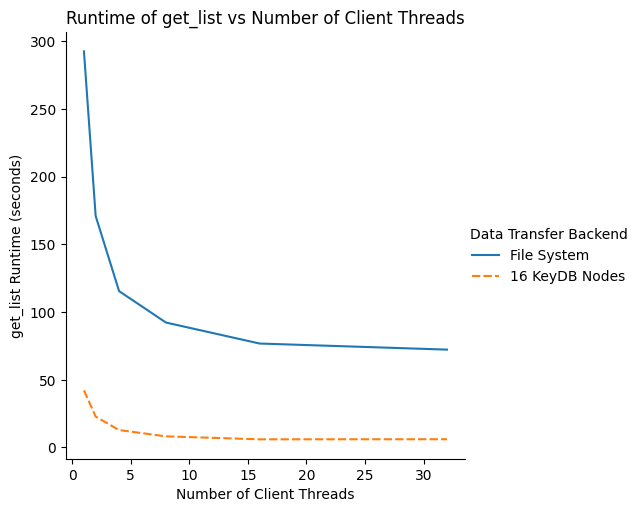

In [74]:

(
    sns.relplot(
        data=concatenated,
        kind="line",
        x="client_threads",
        y="get_list_mean",
        hue="backend",
        style="backend",
    )
    .set(
        title="Runtime of get_list vs Number of Client Threads",
        xlabel="Number of Client Threads",
        ylabel="get_list Runtime (seconds)",
    )
    .legend
    .set_title("Data Transfer Backend")
)

### Get List Loop Runtime

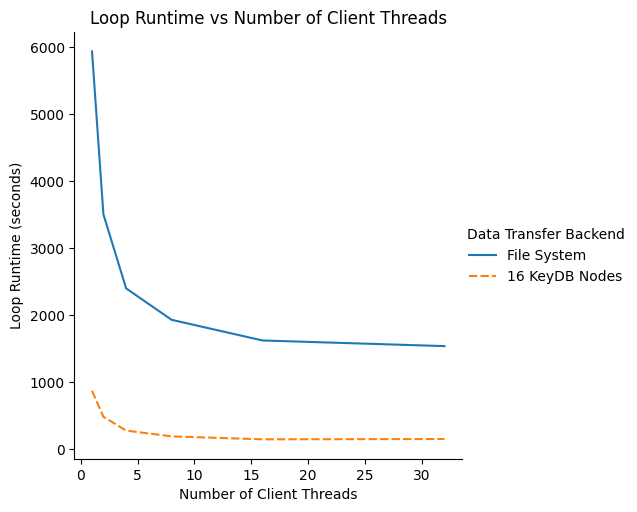

In [75]:
(
    sns.relplot(
        data=concatenated,
        kind="line",
        x="client_threads",
        y="loop_time",
        hue="backend",
        style="backend",
    )
    .set(
        title="Loop Runtime vs Number of Client Threads",
        xlabel="Number of Client Threads",
        ylabel="Loop Runtime (seconds)",
    )
    .legend
    .set_title("Data Transfer Backend")
)

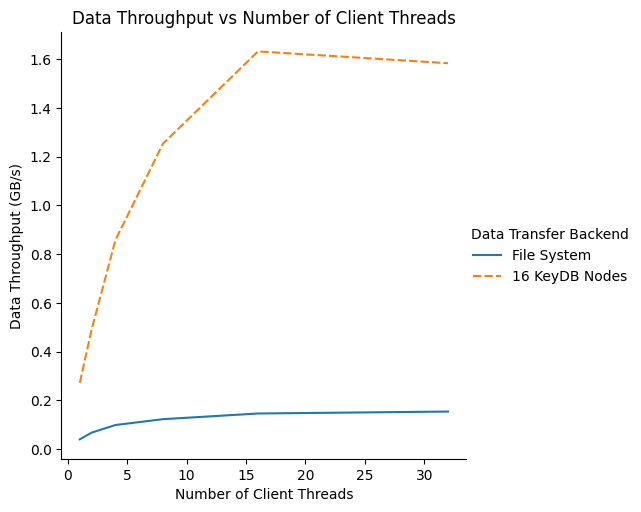

In [76]:
throughput_df = concatenated.copy()
throughput_df["throughput"] = (throughput_df["client_nodes"]
                               * throughput_df["client_per_node"]
                               * throughput_df["tensor_bytes"]
                               * throughput_df["t_per_dataset"]
                               * throughput_df["iterations"]
                               / throughput_df["loop_time"]
                               / 1e9)
(
    sns.relplot(
        data=throughput_df,
        kind="line",
        x="client_threads",
        y="throughput",
        hue="backend",
        style="backend",
    )
    .set(
        title="Data Throughput vs Number of Client Threads",
        xlabel="Number of Client Threads",
        ylabel="Data Throughput (GB/s)",
    )
    .legend
    .set_title("Data Transfer Backend")
)